In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.linear_model import LogisticRegression

In [23]:
(train_pool_X, train_pool_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
train_X, Pool_X, train_y,  Pool_y = train_test_split(train_pool_X, train_pool_y, train_size=50, random_state=42)
print(train_X.shape, Pool_X.shape, train_y.shape, Pool_y.shape, test_X.shape, test_y.shape)


(50, 28, 28) (59950, 28, 28) (50,) (59950,) (10000, 28, 28) (10000,)


In [24]:
train_pool_X = train_pool_X.reshape(train_pool_X.shape[0], -1)
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
Pool_X = Pool_X.reshape(Pool_X.shape[0], -1)
print(train_pool_X.shape, train_X.shape, test_X.shape, Pool_X.shape)

(60000, 784) (50, 784) (10000, 784) (59950, 784)


In [25]:
model = LogisticRegression()


In [26]:
def add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample=1,seed=0):
    np.random.seed(seed)
    random_indices = np.random.choice(pool_X_train.shape[0], size=number_of_sample, replace=False)
    labeled_X = pool_X_train[random_indices]
    labeled_y = pool_y_train[random_indices]
    train_X = np.concatenate((train_X, labeled_X), axis=0)
    train_y = np.concatenate((train_y, labeled_y), axis=0)
    pool_X_train = np.delete(pool_X_train, random_indices, axis=0)
    pool_y_train = np.delete(pool_y_train, random_indices)
    return train_X, train_y, pool_X_train, pool_y_train

In [27]:
def active_learning_sampling(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test,num_iterations=3, number_of_sample=1,seed=0):
    accuracy_iteration = []
    for _ in range(num_iterations):
        model = LogisticRegression()
        train_X, train_y, pool_X_train, pool_y_train = add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample,seed)
        model.fit(train_X, train_y)
        y_pred = model.predict(pool_X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_iteration.append(accuracy)
        
    accuracy_iteration = np.array(accuracy_iteration)
    mean_accuracy = np.mean(accuracy_iteration)
    std_accuracy = np.std(accuracy_iteration)
    print(mean_accuracy, std_accuracy)
    return accuracy_iteration , mean_accuracy, std_accuracy

0.6672133333333333 0.0036452465242041354
0.6753199999999999 0.010336292049537558
0.6810133333333332 0.009233335740071886
0.6914466666666667 0.01039409233918748
0.6869999999999999 0.006292005509639443
0.6745666666666666 0.00797535091530285
0.6755800000000002 0.01290401487909868
0.6808599999999999 0.010979362458722282
0.6757933333333332 0.013248469932620738
0.6792066666666667 0.013739891637935939
0.6852199999999999 0.01473070263089986
0.69532 0.008384684450433024
0.6939733333333333 0.01063199364601433
0.6626 0.005695027070465364


Text(0.5, 0, 'Number of iterations')

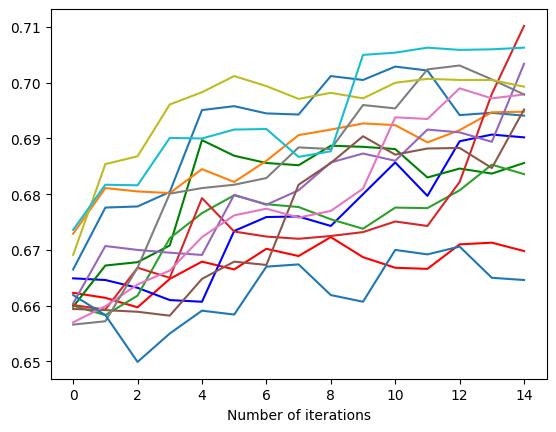

In [43]:
accuracy_after_random_sampling1,mean_accuracy1,std_accuracy1 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,42)
accuracy_after_random_sampling2,mean_accuracy2,std_accuracy2 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,43)
accuracy_after_random_sampling3,mean_accuracy3,std_accuracy3 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,44)
accuracy_after_random_sampling4,mean_accuracy4,std_accuracy4 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,45)
accuracy_after_random_sampling5,mean_accuracy5,std_accuracy5 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,46)
accuracy_after_random_sampling6,mean_accuracy6,std_accuracy6 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,47)
accuracy_after_random_sampling7,mean_accuracy7,std_accuracy7 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,48)
accuracy_after_random_sampling8,mean_accuracy8,std_accuracy8 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,49)
accuracy_after_random_sampling9,mean_accuracy9,std_accuracy9 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,50)
accuracy_after_random_sampling10,mean_accuracy10,std_accuracy10 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,51)
accuracy_after_random_sampling11,mean_accuracy11,std_accuracy11 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,52)
accuracy_after_random_sampling12,mean_accuracy12,std_accuracy12 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,53)
accuracy_after_random_sampling13,mean_accuracy13,std_accuracy13 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,54)
accuracy_after_random_sampling14,mean_accuracy14,std_accuracy14 = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y,15,1,55)
num_iterations=15
iterations = range(1, num_iterations + 1)
plt.plot( accuracy_after_random_sampling1, '-',color='red' ,label='Accuracy')
plt.plot( accuracy_after_random_sampling2, '-', color='blue',label='Accuracy')

plt.plot( accuracy_after_random_sampling3, '-', color='green',label='Accuracy')

plt.plot( accuracy_after_random_sampling4, '-', label='Accuracy')  
plt.plot( accuracy_after_random_sampling5, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling6, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling7, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling8, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling9, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling10, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling11, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling12, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling13, '-', label='Accuracy')
plt.plot( accuracy_after_random_sampling14, '-', label='Accuracy')

plt.xlabel('Number of iterations')



In [55]:
all_accuracy_iterations=np.array([accuracy_after_random_sampling1,accuracy_after_random_sampling2,accuracy_after_random_sampling3,accuracy_after_random_sampling4,accuracy_after_random_sampling5,accuracy_after_random_sampling6,accuracy_after_random_sampling7,accuracy_after_random_sampling8,accuracy_after_random_sampling9,accuracy_after_random_sampling10,accuracy_after_random_sampling11,accuracy_after_random_sampling12,accuracy_after_random_sampling13,accuracy_after_random_sampling14])
all_accuracy_iterations.shape
mean_accuracy_all_seeds = np.mean(all_accuracy_iterations, axis=0)
std_accuracy_all_seeds = np.std(all_accuracy_iterations, axis=0)
print(mean_accuracy_all_seeds)
print(std_accuracy_all_seeds)



[0.66317857 0.66727857 0.66824286 0.67211429 0.67775    0.67962857
 0.68047143 0.68160714 0.68287857 0.68535714 0.68759286 0.68746429
 0.68944286 0.69012143 0.69235   ]
[0.00527138 0.00975977 0.00983875 0.01150502 0.01220209 0.01129225
 0.0096757  0.00887963 0.01058491 0.01246754 0.01144031 0.01239047
 0.0105201  0.01102887 0.0124434 ]


In [ ]:
def active_learning_random_sampling(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, num_iterations=25, number_of_sample=1):
    

In [192]:
mean_accuracy, std_accuracy = active_learning_random_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y)

Mean accuracy after seed 1: 0.683604
Standard deviation after seed 1: 0.011627569995489162
Mean accuracy after seed 2: 0.6883839999999999
Standard deviation after seed 2: 0.020469424613310454
Mean accuracy after seed 3: 0.6844199999999999
Standard deviation after seed 3: 0.011185562122665098
Mean accuracy after seed 4: 0.6857120000000001
Standard deviation after seed 4: 0.0072942892731231905
Mean accuracy after seed 5: 0.691864
Standard deviation after seed 5: 0.022255567932542193
Mean accuracy after seed 6: 0.6757079999999999
Standard deviation after seed 6: 0.009035880477297167
Mean accuracy after seed 7: 0.6742959999999999
Standard deviation after seed 7: 0.018430311554610248
Mean accuracy after seed 8: 0.678608
Standard deviation after seed 8: 0.008757256191296438
Mean accuracy after seed 9: 0.6756040000000002
Standard deviation after seed 9: 0.0067825352192229715
Mean accuracy after seed 10: 0.693516
Standard deviation after seed 10: 0.02398682438339849
Mean accuracy after seed 11

print(mean_accuracy)

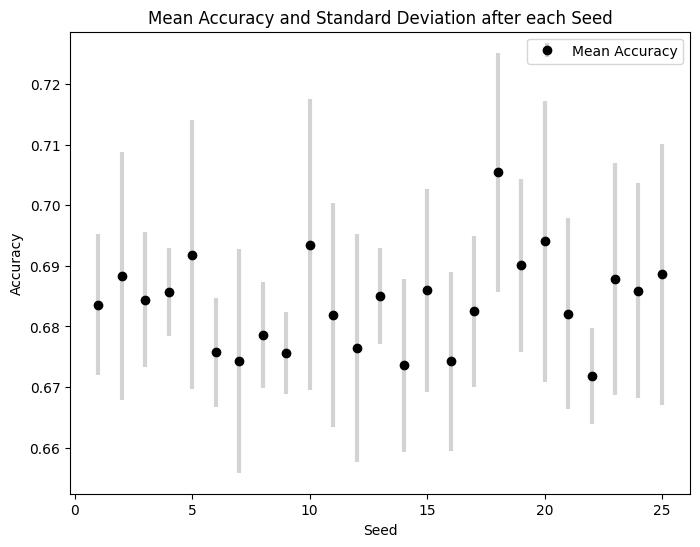

In [194]:

def plot_mean_and_std(mean_accuracy_list, std_accuracy_list):
    num_iterations = len(mean_accuracy_list)

    plt.figure(figsize=(8, 6))
    plt.errorbar(range(1, num_iterations + 1), mean_accuracy_list, yerr=std_accuracy_list, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0,label='Mean Accuracy')
    plt.xlabel('Seed')
    plt.ylabel('Accuracy')
    plt.title('Mean Accuracy and Standard Deviation after each Seed')
    plt.legend();

plot_mean_and_std(mean_accuracy, std_accuracy)


In [195]:
def entropy(p, epsilon=1e-7):
    p = np.clip(p, epsilon, 1.0 - epsilon)  
    return -np.sum(p * np.log2(p), axis=1)

In [196]:
def margin_sampling(probabilities):
    sorted_probs = np.sort(probabilities, axis=1)
    return sorted_probs[:, -1] - sorted_probs[:, -2]

In [197]:
def least_confident(probabilities):
    return 1 - np.max(probabilities, axis=1)

In [198]:

def active_learning(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, acquisition_function, num_iterations, number_of_sample=1):
    accuracy_iteration = []

    for _ in range(num_iterations):
        model = LogisticRegression()
        model.fit(train_X, train_y)

        pool_probabilities = model.predict_proba(pool_X_train)
        acquisition_scores = acquisition_function(pool_probabilities)

        selected_indices = np.argsort(acquisition_scores)[-number_of_sample:]

        labeled_X = pool_X_train[selected_indices]
        labeled_y = pool_y_train[selected_indices]

        train_X = np.concatenate((train_X, labeled_X), axis=0)
        train_y = np.concatenate((train_y, labeled_y), axis=0)

        pool_X_train = np.delete(pool_X_train, selected_indices, axis=0)
        pool_y_train = np.delete(pool_y_train, selected_indices)
        
        
        y_pred = model.predict(pool_X_test)
        accuracy = accuracy_score(y_test, y_pred)
        # print("Accuracy score after iteration {}: {:.4f} ".format(_ + 1, accuracy))

        accuracy_iteration.append(accuracy)

    return  accuracy_iteration


In [199]:
def active_learning_sampling(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test,num_iterations=700, number_of_sample=1):
    accuracy_iteration = []

    for _ in range(num_iterations):
        model = LogisticRegression()
        train_X, train_y, pool_X_train, pool_y_train = add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample)

        model.fit(train_X, train_y)
        y_pred = model.predict(pool_X_test)

        accuracy = accuracy_score(y_test, y_pred)
        # print("Accuracy score after iteration {}: {:.4f} ".format(_ + 1, accuracy))

        accuracy_iteration.append(accuracy)

    return accuracy_iteration

In [200]:
accuracy_after_random_sampling = active_learning_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y)


/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [201]:
accuracy_least_entropy = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y, acquisition_function=entropy,
                                                                                                 num_iterations=700,
                                                                                                 number_of_sample=1)

/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [202]:
accuracy_least_margin = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=margin_sampling,
                                                                                                 num_iterations=500,
                                                                                                 number_of_sample=1)

In [203]:
accuracy_confident = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=least_confident,
                                                                             num_iterations=500,
                                                                             number_of_sample=1)

/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

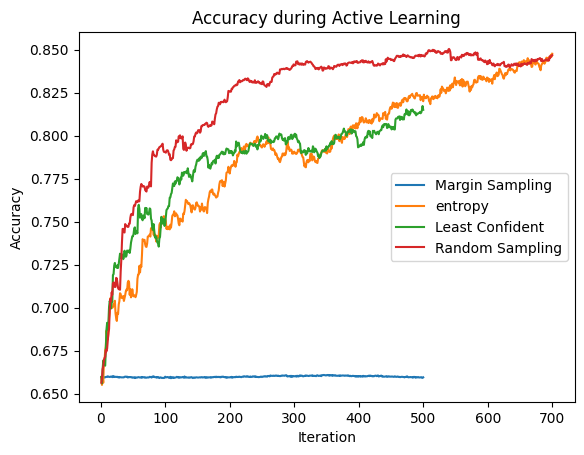

In [205]:
plt.plot(range(1, len(accuracy_least_margin) + 1), accuracy_least_margin,label='Margin Sampling')
plt.plot(range(1, len(accuracy_least_entropy) + 1), accuracy_least_entropy, label='entropy')
plt.plot(range(1, len(accuracy_confident) + 1), accuracy_confident,label='Least Confident')
plt.plot(range(1, len(accuracy_after_random_sampling) + 1), accuracy_after_random_sampling,label='Random Sampling')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy during Active Learning')
plt.legend();